In [2]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
import polars as pl
from datetime import timedelta
import datetime 
import json 
import toml
import holidays
import sys

features = toml.load(r'C:\Users\N000193384\Documents\sncf_project\sncf_playground\data\features.toml')
times_cols = features['times_cols']
macro_horizon = features['MACRO_HORIZON']
p = Path(features['ABS_DATA_PATH'])
sys.path.insert(1, p)

from src.preprocessing.times import (
    from_day_to_time_fe,
    get_covid_table,
)
from src.preprocessing.quality import trim_timeseries, minimum_length_uid
from src.models.forecast.direct import DirectForecaster
from src.preprocessing.lags import get_significant_lags
from src.preprocessing.times import get_basic_holidays
from src.project_utils import load_data
from src.models.lgb_wrapper import GBTModel
from src.preprocessing.validation import freeze_validation_set
from src.preprocessing.lags import compute_autoreg_features

ts_uid = features["ts_uid"]
date_col = features['date_col']
y = features['y']
submit = False 
flist = features["flist"]
long_horizon = np.arange(macro_horizon)
chains = np.array_split(long_horizon, 6)
exog = ["job", "ferie", "vacances"] + times_cols

with open('data/params.json', 'rb') as stream:
    params_q = json.load(stream)

in_dt = datetime.date(2020, 6, 1)

covid_df = get_covid_table(2015, 2024)
df_dates = df_dates = get_basic_holidays()
holidays_fe = list(filter(lambda x: date_col not in x, df_dates.columns))
covid_fe = list(filter(lambda x: date_col not in x, covid_df.columns))
exog = exog + holidays_fe + covid_fe

train_data, test_data, submission = load_data(p)

test_data = (
    test_data.pipe(from_day_to_time_fe, time=date_col, frequency="day")
    .join(df_dates, how="left", on=[date_col])
    .join(covid_df, how="left", on=[date_col])
)

train_data = (
    train_data.pipe(trim_timeseries, target="y", uid=ts_uid, time=date_col)
    .pipe(from_day_to_time_fe, time=date_col, frequency="day")
    .join(df_dates, how="left", on=[date_col])
    .join(
        covid_df.with_columns(
            pl.lit(np.where(np.any(covid_df != 0, axis=1), 0.01, 1)).alias(
                "covid_weight"
            )
        ),
        how="left",
        on=[date_col],
    )
    # sncf strike | 2019-12-01 to 2021-11-01
    .filter(
        (pl.col(date_col) >= in_dt)
        & (pl.col(date_col) != pl.datetime(2019, 12, 1))
        & (pl.col(date_col) != pl.datetime(2021, 11, 1))
    )
)

good_ts = minimum_length_uid(
    train_data, target=y, uid=ts_uid, time=date_col, min_length=round(364 * 1.2)
)
train_data = train_data.filter(pl.col(ts_uid).is_in(good_ts))
# test.
left_term = train_data.select([date_col, ts_uid, "y"] + exog).with_columns(
    pl.lit(1).alias("train")
)
right_term = test_data.select([date_col, ts_uid, "y"] + exog).with_columns(
    pl.lit(0).alias("train")
)
full_data = pl.concat((left_term, right_term), how="vertical_relaxed")
del left_term, right_term

# define params
significant_lags = get_significant_lags(train_data, date_col=date_col, target=y)
significant_lags = [x for x in significant_lags if x%7 == 0 and x<= macro_horizon][1:]

autoreg_dict = {
        ts_uid: {
            "groups": ts_uid,
            "horizon": lambda horizon: np.int32(horizon),
            "wins": np.array([28, 56]),
            "shifts": lambda horizon: np.int32([horizon]),
            "lags": lambda horizon: np.array(significant_lags) + horizon,
            "funcs": np.array(flist),
        },
        "ts_uid_dow": {
            "groups": [ts_uid, "day_of_week"],
            "horizon": lambda horizon: np.int32(np.ceil(horizon / 7) + 1),
            "wins": np.array([4, 8]),
            "shifts": lambda horizon: np.int32([np.ceil(horizon / 7) + 1]),
            "lags": lambda horizon: np.arange(1, 7) + np.ceil(horizon / 7) + 1,
            "funcs": np.array(flist),
        }
    }

for key in autoreg_dict.keys():
    autoreg_dict[key]["horizon"] = autoreg_dict[key]["horizon"](macro_horizon)
    autoreg_dict[key]["shifts"] = autoreg_dict[key]["shifts"](macro_horizon)
    autoreg_dict[key]["lags"] = autoreg_dict[key]["lags"](macro_horizon)

cat_cols = ['week', 'month', 'day_of_week', "job", "ferie", "vacances"]
target = "y"

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
sc = RobustScaler().set_output(transform='polars')

In [ ]:
'''import os
from typing import Dict, List

import lightgbm as lgb
import numpy as np
import optuna
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


def objective(
    trial: optuna.trial,
    train_data: pd.DataFrame,
    exog: List,
    seed: int = 12345,
):
    """_summary_

    Args:
        trial (optuna.trial): _description_
        train_x (pd.DataFrame): _description_
        test (pd.DataFrame): _description_
        features (List): _description_
        target (str, optional): _description_. Defaults to "".
        seed (int, optional): _description_. Defaults to 12345.

    Returns:
        _type_: _description_
    """
    optuna_params = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "objective": trial.suggest_categorical(
            "objective", ["regression", "huber", "regression_l1", "quantile"]
        ),
        "metric": trial.suggest_categorical("metric", ["rmse"]),
        "alpha": trial.suggest_categorical(
            "alpha",
            [0.5, 0.52, 0.55, 0.57, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.7, 0.69, 0.7],
        ),
        "force_row_wise": trial.suggest_categorical("force_row_wise", [True, False]),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=False),
        "max_depth": trial.suggest_int("max_depth", 4, 15),
        "sub_row": trial.suggest_categorical("sub_row", [0.6, 0.7, 0.8, 1.0]),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 4, log=True),
        "min_child_samples": trial.suggest_float(
            "min_child_samples", 20, 5000, log=False
        ),
        "num_iterations": trial.suggest_int(
            "n_estimators",
            200,
            3000,
        ),
        "num_leaves": trial.suggest_int("num_leaves", 25, 800),
        "max_bins": trial.suggest_int("max_bins", 24, 1000),
        "min_data_in_bin": trial.suggest_int("min_data_in_bin", 25, 1000),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 1000),
        "feature_fraction_seed": trial.suggest_categorical(
            "feature_fraction_seed", [seed]
        ),
        "bagging_seed": trial.suggest_categorical("bagging_seed", [seed]),
        "seed": trial.suggest_categorical("seed", [seed]),
        "verbose": trial.suggest_categorical("verbose", [-1]),
    }

    horizon = 181
    lags = [x for x in significant_lags if x <= horizon]
    win_list =  [ x for x in significant_lags if x % 7 == 0 and x <= horizon][1:] 

    autoreg_dict = {
        ts_uid : {
            'groups' : ts_uid,
            'horizon': lambda horizon : np.int32(horizon),
            'wins' : np.array(win_list), 
            'shifts' : lambda horizon : np.int32([horizon, horizon+28, horizon+56]), 
            'lags' : lambda horizon : np.array(significant_lags) + horizon,
            'funcs' : np.array(flist)
        },
        "ts_uid_dow" : {
            'groups':[ts_uid, 'day_of_week'],
            'horizon' : lambda horizon : np.int32(np.ceil(horizon /7) + 1),
            'wins' : np.array([4, 8, 12, 16, 20]), 
            'shifts' : lambda horizon : np.int32([np.ceil(horizon /7) + 1, np.ceil(horizon /7) + 4]), 
            'lags' : lambda horizon : np.arange(1, 7) + np.ceil(horizon/7)+1,
            'funcs' : np.array(flist)
        }
    }


    effect_m = GBTModel(params=optuna_params, 
                        early_stopping_value=200, 
                        features= None,
                        custom_loss=optuna_params["objective"], 
                        categorical_features=[]
                        )


    dir_forecaster = DirectForecaster(
        model=effect_m,
        ts_uid=ts_uid,
        forecast_range=np.arange(horizon),
        target_str="y",
        date_str="date",
        exogs=exog,
        features_params=autoreg_dict
    )

    dir_forecaster.fit(train_data=train_data)
    return dir_forecaster.evaluate()["mae"].values[0]


def parameters_tuning(
    initial_params: Dict,
    tuning_objective,
    n_trials: int = 25,
    njobs: int = -1,
):
    """parameter for tuning over sudy

    Args:
        tuning_objective (_type_): _description_
        n_trials (int, optional): _description_. Defaults to 25.

    Returns:
        _type_: _description_

    example :

    func = lambda trial: objective(trial=trial,
                                    train_x=train_x,
                                    test=residualised_test,
                                    covariates=covariates,
                                    target=y,
                                    seed=12345
                                    )
    study_df, best_params = parameters_tuning(tuning_objective=func, n_trials=25, initial_params={})
        print(best_params)
        print(study_df)
        study_df.to_csv('bparamslgb_new.csv', sep="|", index=False)
    """
    study = optuna.create_study(direction="minimize")
    # study.enqueue_trial(initial_params)
    study.optimize(tuning_objective, n_trials=n_trials, n_jobs=njobs)
    print("Number of finished trials:", len(study.trials))
    print("Best trial:", study.best_trial.params)
    study_df = study.trials_dataframe()
    return study_df, study.best_params


func = lambda trial: objective(trial=trial,
                                train_data=train_data,
                                exog=exog,
                                seed=12345
                                )
study_df, best_params = parameters_tuning(tuning_objective=func, n_trials=30, initial_params={}, njobs=10)
print(best_params)
print(study_df)
study_df.to_csv('bparamslgb_new.csv', sep="|", index=False)'''

# evaluate

In [3]:
base_col = [ts_uid, date_col, y, "day_of_year"]

from src.preprocessing.lags import reference_shift_from_day
from src.analysis.metrics import display_metrics

train_data, test_data, submission = load_data(p)


def freeze_validation_set(
    df: pl.DataFrame,
    date: str,
    val_size: int,
    return_train: bool = True,
) -> pl.DataFrame:
    max_dt = df[date].max()
    cut = max_dt - timedelta(days=val_size)
    valid = df.filter(pl.col(date) > cut)  # .select([ts_uid, date, target])
    if return_train:
        train = df.filter(pl.col(date) <= cut)
        return train, valid
    else:
        return valid


statsmodel_valid = (pl.read_csv('out/nixtla_validation.csv', separator=",", infer_schema_length=1000)
                    .rename({"unique_id":ts_uid, "ds":date_col})
                    .select([ts_uid, date_col, 'HoltWinters', 'AutoETS', "AutoARIMA",
                              'AutoTheta', 'AutoTBATS', 'arithmetic_forecast_ensamble']
                              ).with_columns(pl.col(date_col).cast(pl.Date).alias(date_col))
)


direct_global_valid = (pl.read_csv('out/global_direct_lgb.csv', separator=",", infer_schema_length=1000)
                     .with_columns(pl.col(date_col).cast(pl.Date).alias(date_col))
)


nfcst  = ["TimesNet"	,"NHITS"	,"NBEATSx"	, "PatchTST"	,"TSMixerx"	, "iTransformer", "ensamble_forecast"]
neural_fcst_model = pl.read_csv("out/neural_validation.csv", separator=",", infer_schema_length=1000) 
for col in nfcst:
    neural_fcst_model = neural_fcst_model.with_columns(pl.lit(np.expm1(neural_fcst_model[col])).alias(col))
neural_fcst_model = neural_fcst_model.rename({"unique_id":ts_uid, "ds":date_col, "ensamble_forecast":"deep_ensemble"})
neural_fcst_model = neural_fcst_model.with_columns(pl.col(date_col).cast(pl.Date))
nfcst = nfcst[:-1] + ["deep_ensemble"]

direct_local_valid = (pl.read_csv('out/local_direct_lgb.csv', separator=",", infer_schema_length=1000)
                     .with_columns(pl.col(date_col).cast(pl.Date).alias(date_col))
)


prophet_m = (pl.read_csv('out/prophet.csv', infer_schema_length=1000)
                     .with_columns(pl.col("ds").str.to_datetime().cast(pl.Date).alias(date_col))
                     .rename({"unique_id":ts_uid, "yhat":"prophet_yhat"})
)

prophet_m = prophet_m.with_columns(pl.lit(np.expm1(prophet_m['prophet_yhat'])))


chain_global_valid = (pl.read_csv('out/global_chain_lgb.csv', separator=",", infer_schema_length=1000)
                     # .rename({"y_hat":"global_chain_y_hat"})
                     .with_columns(pl.col(date_col).cast(pl.Date).alias(date_col))
)

baseline = (train_data
    .pipe(from_day_to_time_fe, time="date", frequency="day")
    .pipe(reference_shift_from_day,    
        target_col=y, 
        ts_uid=ts_uid,
        dayofyear_col="day_of_year"       )
    .pipe(freeze_validation_set, return_train=False, date=date_col, val_size=181)
    .with_columns(
        pl.coalesce(
            pl.col('reference_y'), 
            pl.col('reference_y').mean().over(ts_uid),
            pl.col('reference_y').mean(),
            0
            )
    )
    .join( statsmodel_valid, how="left",  on=[ts_uid, date_col]    )
    .join(
            direct_global_valid,
            how="left", 
            on=[ts_uid, date_col]
        )
    .join(
            direct_local_valid,
            how="left", 
            on=[ts_uid, date_col]
        )
    .join(
            chain_global_valid,
            how="left", 
            on=[ts_uid, date_col]
        )
    .join(val_set.select([ts_uid, date_col, 'forecast_mlp']), how="left", on = [ts_uid, date_col])
    .join(neural_fcst_model, how="left", on = [ts_uid, date_col])
    .join(prophet_m, how="left", on = [ts_uid, date_col])

    )

forecast_cols = [
                'HoltWinters', 'AutoETS', "AutoARIMA",
                 'AutoTheta', 'AutoTBATS', "prophet_yhat",
                 'arithmetic_forecast_ensamble',
                 "reference_y", "global_direct_y_hat", 
                 "local_direct_y_hat", "global_chain_y_hat",
                 "forecast_mlp"
                 ] + nfcst



baseline = baseline.with_columns(
    pl.concat_list(["reference_y", "global_direct_y_hat", "global_chain_y_hat"]).list.mean().alias('ensemble'),
    pl.concat_list(forecast_cols).list.mean().alias('all_ensemble'),
    pl.concat_list(["global_direct_y_hat", "global_chain_y_hat"]).list.mean().alias('lgb_ensemble'),                   
)

forecast_cols += ["ensemble", "all_ensemble", "lgb_ensemble"]

metrics_output_df = []
for col in forecast_cols:
    metrics_output_df.append(
        display_metrics(
        baseline[y].to_numpy(), 
        np.clip(baseline[col].fill_null(0).to_numpy(), a_min=0, a_max=None),
        name=col
        ).transpose()
    )

allmet = pd.concat(metrics_output_df, axis=1)
allmet.columns = allmet.iloc[0, :]
display(allmet)


"""
with log :

fname	baseline	lgb	lgb_chains
fname	baseline	lgb	lgb_chains
rmse	4123.810547	4999.597825	5121.101499
bias	450.242163	1372.905182	1368.364562
mape	2.105475	1.154826	1.152257
wfiab	0.691066	0.650323	0.651813
mae	1359.627197	1538.938512	1532.378134

without log : 

fname	baseline	lgb	lgb_chains
fname	baseline	lgb	lgb_chains
rmse	4139.15247	2512.594178	2364.075077
bias	421.788203	227.739412	235.493706
mape	2.774925	1.806896	1.947053
wfiab	0.68463	0.797759	0.806641
mae	1387.952732	890.065842	850.979446

wo log | w covid 

fname	baseline	lgb_chains
fname	baseline	lgb_chains
rmse	4139.15247	2292.385397
bias	421.788203	229.864649
mape	2.774925	2.033086
wfiab	0.68463	0.80966
mae	1387.952732	837.692923

fname	baseline	lgb	lgb_chains
fname	baseline	lgb	lgb_chains
rmse	4139.15247	2150.431433	2273.18081
bias	421.788203	101.213962	159.685819
mape	2.774925	2.723164	2.632403
wfiab	0.68463	0.808726	0.807924
mae	1387.952732	841.800341	845.329485


fname	baseline	lgb	lgb_chains
fname	baseline	lgb	lgb_chains
rmse	4143.447587	2214.968268	2127.142468
bias	462.428658	70.666715	109.148351
mape	1.934116	1.718658	1.738316
wfiab	0.692717	0.8319	0.834986
mae	1365.34212	746.9146	733.203599

"""



fname,HoltWinters,AutoETS,AutoARIMA,AutoTheta,AutoTBATS,prophet_yhat,arithmetic_forecast_ensamble,reference_y,global_direct_y_hat,local_direct_y_hat,...,TimesNet,NHITS,NBEATSx,PatchTST,TSMixerx,iTransformer,deep_ensemble,ensemble,all_ensemble,lgb_ensemble
fname,HoltWinters,AutoETS,AutoARIMA,AutoTheta,AutoTBATS,prophet_yhat,arithmetic_forecast_ensamble,reference_y,global_direct_y_hat,local_direct_y_hat,...,TimesNet,NHITS,NBEATSx,PatchTST,TSMixerx,iTransformer,deep_ensemble,ensemble,all_ensemble,lgb_ensemble
rmse,2643.192183,4021.409043,4050.877011,3873.412719,4007.427651,5653.938214,3602.650886,4064.678754,2263.683753,13113.160076,...,2686.140619,13446666661513374.0,1309876.736601,3942.925133,2732.456539,3003.768148,3212.679427,2186.027998,747037036754656.25,2185.204138
bias,23.092674,539.862761,479.565213,273.861181,678.540183,-1399.508116,752.288948,414.177174,152.433022,1283.888808,...,356.610968,-115674289405892.34375,-42924.384894,1066.179344,9.131984,501.502882,704.96722,240.274162,-6426349413508.905273,168.412275
forecast_congruence,2643.098044,3985.016923,4022.400313,3863.729063,3949.574553,5478.005786,3523.239709,4043.532369,2258.551377,13050.190238,...,2662.370408,13446203397825892.0,1309176.57445,3796.049749,2732.448246,2961.614876,3134.38677,2172.788717,747011299883112.0,2178.710315
wfiab,0.79333,0.666623,0.670081,0.68289,0.687228,0.622415,0.690997,0.711489,0.843143,0.174112,...,0.782092,0.70106,0.678641,0.67407,0.779044,0.759093,0.759407,0.835109,0.784627,0.846707
mae,970.5055,1574.163585,1564.214608,1530.844167,1434.185529,1914.217603,1416.251857,1350.735858,729.272842,5328.37353,...,1006.127572,115674289408009.28125,45350.591853,1484.362075,1034.200524,1105.517735,1123.794371,777.813077,6426349414953.826172,713.261969
smape,35.296021,49.745057,48.72857,48.18585,46.874209,41.225632,44.616124,44.463872,25.848551,127.523748,...,34.767094,49.435657,43.901175,49.094056,33.498223,36.116508,34.064961,27.491278,40.268916,27.408963


'\nwith log :\n\nfname\tbaseline\tlgb\tlgb_chains\nfname\tbaseline\tlgb\tlgb_chains\nrmse\t4123.810547\t4999.597825\t5121.101499\nbias\t450.242163\t1372.905182\t1368.364562\nmape\t2.105475\t1.154826\t1.152257\nwfiab\t0.691066\t0.650323\t0.651813\nmae\t1359.627197\t1538.938512\t1532.378134\n\nwithout log : \n\nfname\tbaseline\tlgb\tlgb_chains\nfname\tbaseline\tlgb\tlgb_chains\nrmse\t4139.15247\t2512.594178\t2364.075077\nbias\t421.788203\t227.739412\t235.493706\nmape\t2.774925\t1.806896\t1.947053\nwfiab\t0.68463\t0.797759\t0.806641\nmae\t1387.952732\t890.065842\t850.979446\n\nwo log | w covid \n\nfname\tbaseline\tlgb_chains\nfname\tbaseline\tlgb_chains\nrmse\t4139.15247\t2292.385397\nbias\t421.788203\t229.864649\nmape\t2.774925\t2.033086\nwfiab\t0.68463\t0.80966\nmae\t1387.952732\t837.692923\n\nfname\tbaseline\tlgb\tlgb_chains\nfname\tbaseline\tlgb\tlgb_chains\nrmse\t4139.15247\t2150.431433\t2273.18081\nbias\t421.788203\t101.213962\t159.685819\nmape\t2.774925\t2.723164\t2.632403\nwfiab\t

In [4]:
rmsse_df = allmet.loc['rmse'] 
rmsse_df /= rmsse_df['reference_y']
rmsse_df = rmsse_df.to_frame('rmsse').reset_index()
rmsse_df

,fname,rmsse
0,HoltWinters,0.650283
1,AutoETS,0.989355
2,AutoARIMA,0.996604
3,AutoTheta,0.952944
4,AutoTBATS,0.985915
5,prophet_yhat,1.390993
6,arithmetic_forecast_ensamble,0.886331
7,reference_y,1.0
8,global_direct_y_hat,0.556916
9,local_direct_y_hat,3.226125


C:\Users\N000193384\AppData\Local\Temp\ipykernel_39392\1648481898.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmsse_df['fname'] = np.where(rmsse_df['fname'] == "arithmetic_forecast_ensamble", "statistical_ensemble", rmsse_df['fname'])
C:\Users\N000193384\AppData\Local\Temp\ipykernel_39392\1648481898.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmsse_df['fname'] = np.where(rmsse_df['fname'] == "global_direct_y_hat", "LightGBM Direct Forecast", rmsse_df['fname'])
C:\Users\N000193384\AppData\Loc

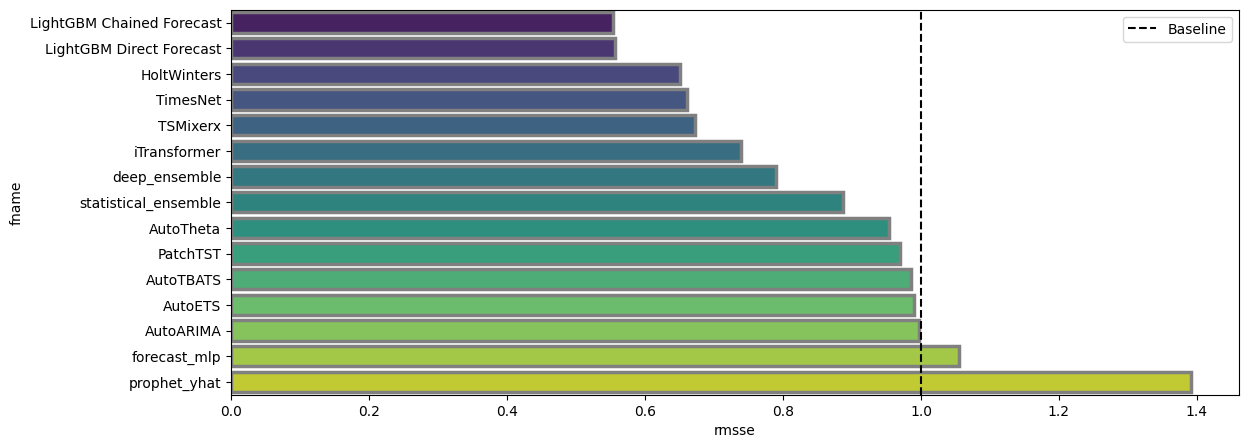

In [5]:
import seaborn as sns 
import matplotlib.pyplot as plt

rmsse_df = rmsse_df.loc[~rmsse_df["fname"].isin(['reference_y', 'all_ensemble', 'ensemble', 'lgb_ensemble', "local_direct_y_hat", "NBEATSx", "NHITS"])]
rmsse_df['fname'] = np.where(rmsse_df['fname'] == "arithmetic_forecast_ensamble", "statistical_ensemble", rmsse_df['fname'])
rmsse_df['fname'] = np.where(rmsse_df['fname'] == "global_direct_y_hat", "LightGBM Direct Forecast", rmsse_df['fname'])
rmsse_df['fname'] = np.where(rmsse_df['fname'] == "global_chain_y_hat", "LightGBM Chained Forecast", rmsse_df['fname'])

plt.figure(figsize=(13, 5))
sns.barplot(rmsse_df.sort_values(by="rmsse"), x="rmsse", y="fname",
            errorbar=("pi", 50), capsize=.4,
    err_kws={"color": ".5", "linewidth": 2.5},
    linewidth=2.5, edgecolor=".5",
    palette="viridis",
)

plt.axvline(1.0, label="Baseline", color="black", linestyle='--')
plt.legend()

In [8]:

def mad_func(x):
        return np.median(np.abs(x - np.median(x)))

(
    train_data
        .sort(by=[ts_uid, date_col])
        .rolling_map(mad_func, window_size=90).over(ts_uid)
)

AttributeError: 'DataFrame' object has no attribute 'rolling_map'

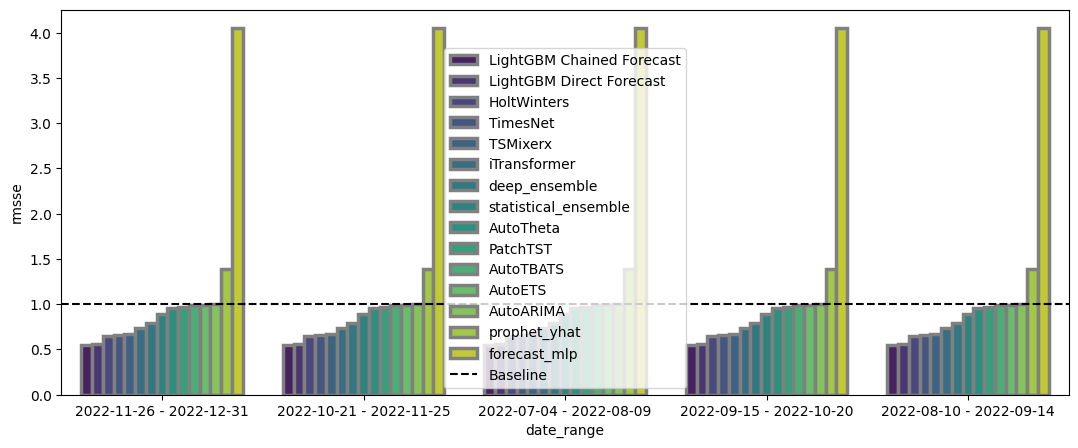

In [15]:
dt = baseline['date'].unique()
split_dt = np.array_split(dt, 5)
bycut = []
for sdt in split_dt:
    metrics_output_df = []
    b_cut = baseline.filter(pl.col("date").is_in(sdt))
    for col in forecast_cols:
        metrics_output_df.append(
            display_metrics(
            baseline[y].to_numpy(), 
            np.clip(baseline[col].fill_null(0).to_numpy(), a_min=0, a_max=None),
            name=col
            ).transpose()
        )

    allmet = pd.concat(metrics_output_df, axis=1)
    allmet.columns = allmet.iloc[0, :]
    rmsse_df = allmet.loc['rmse'] 
    rmsse_df /= rmsse_df['reference_y']
    rmsse_df = rmsse_df.to_frame('rmsse')
    rmsse_df['date_range'] = str(b_cut['date'].min()) + ' - ' + str(b_cut['date'].max())
    # display(allmet)
    bycut.append(rmsse_df)

import seaborn as sns 
import matplotlib.pyplot as plt

data_ = pd.concat(bycut).reset_index()
data_ = data_.loc[~data_["fname"].isin(['reference_y', 'all_ensemble', 'ensemble', 'lgb_ensemble', "local_direct_y_hat", "NBEATSx", "NHITS"])]
data_['fname'] = np.where(data_['fname'] == "arithmetic_forecast_ensamble", "statistical_ensemble", data_['fname'])
data_['fname'] = np.where(data_['fname'] == "global_direct_y_hat", "LightGBM Direct Forecast", data_['fname'])
data_['fname'] = np.where(data_['fname'] == "global_chain_y_hat", "LightGBM Chained Forecast", data_['fname'])

plt.figure(figsize=(13, 5))
sns.barplot(data_.sort_values(by="rmsse"), x="date_range", y="rmsse", hue="fname",     errorbar=("pi", 50), capsize=.4,
    err_kws={"color": ".5", "linewidth": 2.5},
    linewidth=2.5, edgecolor=".5",
    palette="viridis",
)

plt.axhline(1.0, label="Baseline", color="black", linestyle='--')
plt.legend()

In [ ]:
import matplotlib.pyplot as plt 

uids = baseline['station'].unique()
n = 6
choice = np.random.choice(uids, (n, ))

# Création de la figure et des sous-graphiques
fig, axs = plt.subplots(3, 2, figsize=(20, 16))
axs = axs.ravel()  # Aplatir le tableau 2D des axes pour itération facile

# Tracer les graphiques
for i, uid in enumerate(uids, start=0):
    if i ..0 <0 n :2220M§M J YU9°+8µ12
    .012.
        subset_00000000000tr = train_data.filter(
            pl.col(ts_uid)000
             9 == uid, 
            pl.col('date') >= pl.datetime(2021, 1, 1),    B 
            pl.col('date') < subset['date'].min()
            ).sort(by='date')
        subset = baseline.filter(pl.col(ts_uid) == uid).sort(by='date')
        axs[i].plot(subset_tr["date"], subset_tr['y_copy'], label="train", color="brown", alpha=0.8)
        axs[i].scatter(subset["date"], subset['y'], label="real", color="blue", alpha=1, marker="*")
        for col in list(filter(lambda x : 'y_hat' in x ,forecast_cols)):
            axs[i].scatter(subset["date"], subset[col], label=col, alpha=0.5, marker="x")
        axs[i].axvline(subset['date'].min())
        axs[i].set_title(f'Graph for ID {uid}')
        axs[i].legend()

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

overall_valid =  baseline.group_by('date').agg([pl.col(col).sum() for col in forecast_cols])
overall_hist =  train_data.filter(
            pl.col('date') >= pl.datetime(2021, 1, 1), 
            pl.col('date') < subset['date'].min()
            ).sort(by='date').group_by('date').agg(pl.col(y).sum())

overall_realise =  train_data.filter(
            pl.col('date') >= subset['date'].min()
            ).sort(by='date').group_by('date').agg(pl.col(y).sum())

plt.figure(figsize=(25, 6))
plt.scatter(
    overall_hist['date'], overall_hist['y'], label="train", marker="o"
)
plt.scatter(
    overall_realise['date'], overall_realise['y'], label="realise", marker="o"
)
for col in forecast_cols:
    plt.scatter(
        overall_valid['date'], overall_valid[col], label=f"{col}_valid", marker="*"
    )
plt.legend()